# Object recognition using feature matching

The objective of this notebook is to use feature matching to recognize a known object in any given image by applying various image processing techniques using OpenCV.

A feature is a place (at the pixel level) in an image that can be mathematically identified in another image(s). In other words, it is a specific pixel pattern which is unique to an image or an object in an image. A known object can be recognized by finding and matching its features in any given image.

In [1]:
# Import the required libraries
import cv2                         # opencv version 3.4.2
import numpy as np                 # numpy version 1.16.3
import matplotlib.pyplot as plt    # matplotlib version 3.0.3
%matplotlib inline

## 1. Image processing and object extraction

In this section an object is extracted from the given image (source image), so as to detect its features.

In [2]:
# Load the source image
src_img = cv2.imread('images/source.png')

In [3]:
# Function to display an image using matplotlib
def show_image(img, title, colorspace):
    dpi = 96
    figsize = (img.shape[1] / dpi, img.shape[0] / dpi)
    fig, ax = plt.subplots(figsize = figsize, dpi = dpi)
    if colorspace == 'RGB':
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation = 'spline16')
    if colorspace == 'gray':
        plt.imshow(img, cmap = 'gray')
    plt.title(title, fontsize = 12)
    ax.axis('off')
    plt.show()    

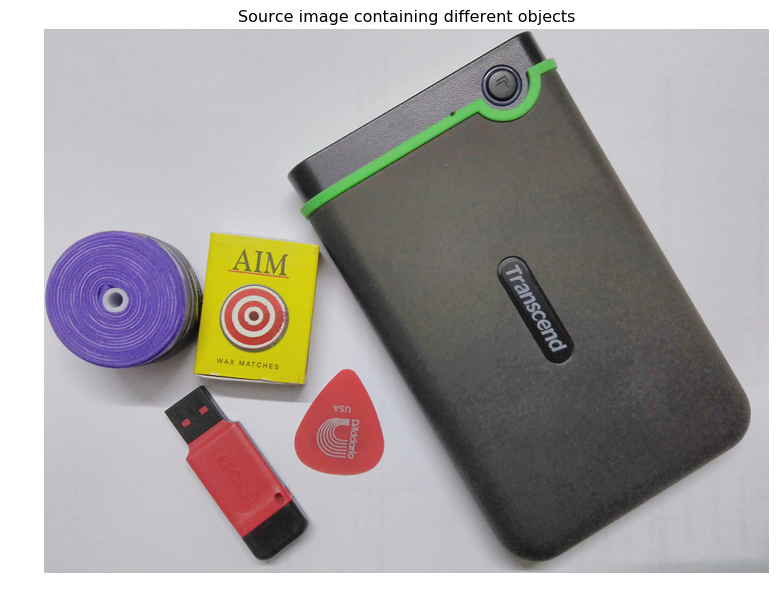

In [4]:
# Display the source image
show_image(src_img, 'Source image containing different objects', 'RGB')

The yellow *matchbox* will be extracted from the above image and its extracted features will be used to recognize this *matchbox* in other images.

There are several approaches to extract an object and it highly depends on the given image. In this case, the matchbox can be uniquely identified by its color and consequently we will use color filtering to accomplish that task. HSV (Hue, Saturation, Value) is better suited than BGR (Blue, Green, Red) values to filter an image based on color.

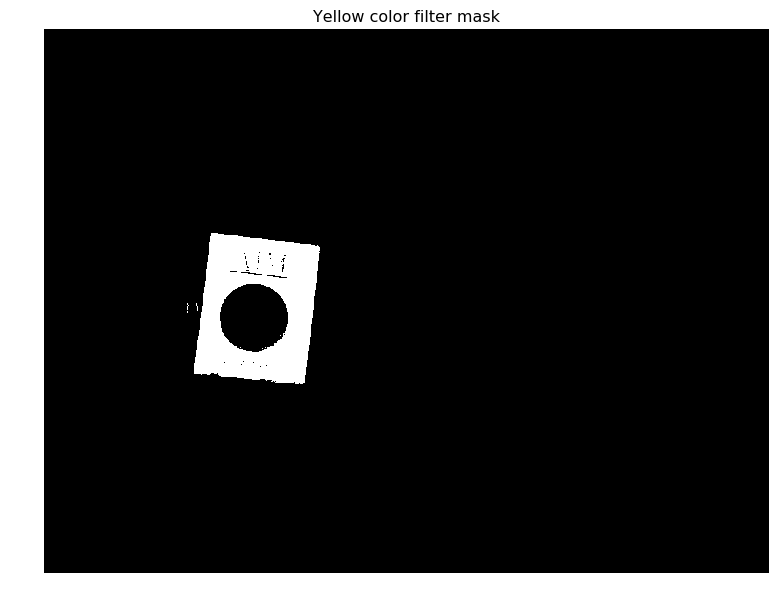

In [5]:
# Change colorspace from BGR to HSV
src_img_hsv = cv2.cvtColor(src_img, cv2.COLOR_BGR2HSV)

# Define limits of yellow HSV values
yellow_lower = np.array([16, 100, 100])
yellow_upper = np.array([45, 255, 255])

# Filter the image and get the mask
mask = cv2.inRange(src_img_hsv, yellow_lower, yellow_upper)

show_image(mask, 'Yellow color filter mask', 'gray')

There are small white noises in the image which are removed by morphological opening. Morphological closing will be used to remove the small black dots in the object.

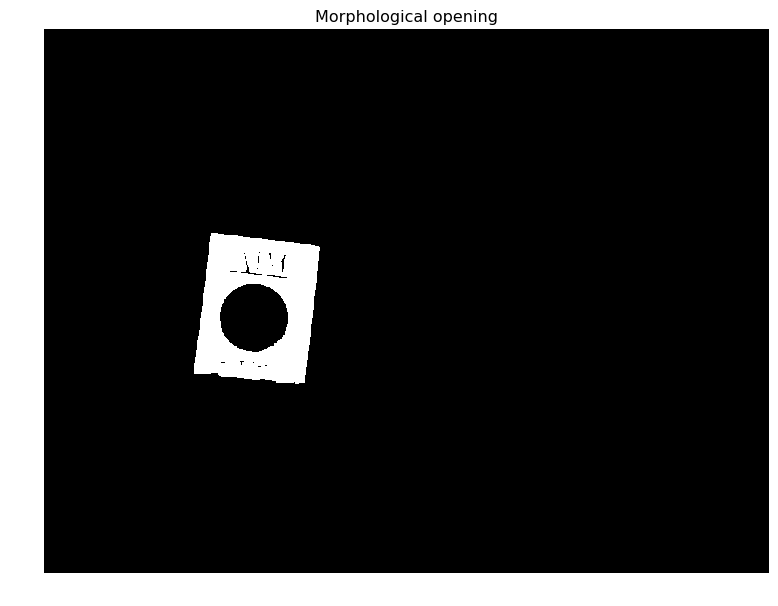

In [6]:
# Remove white noise
kernel = np.ones((5, 5), np.uint8)
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

show_image(opening, 'Morphological opening', 'gray')

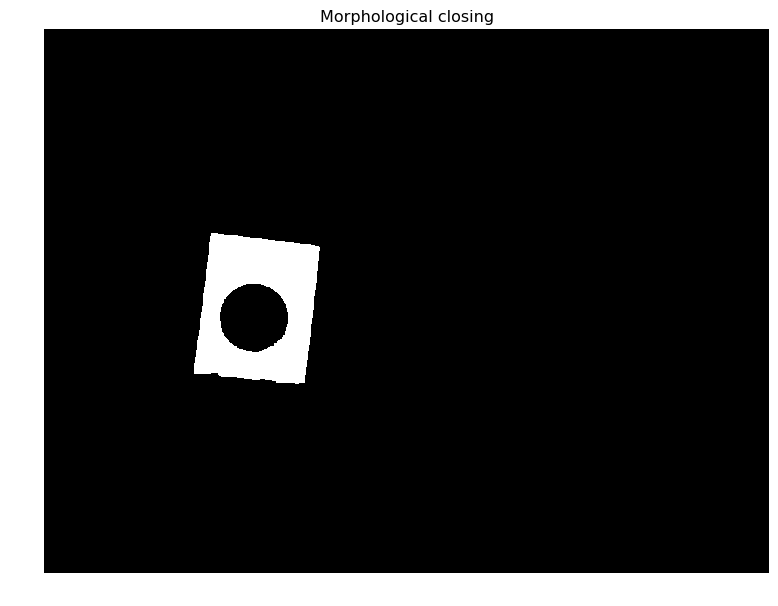

In [7]:
# Remove small black dots
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

show_image(closing, 'Morphological closing', 'gray')

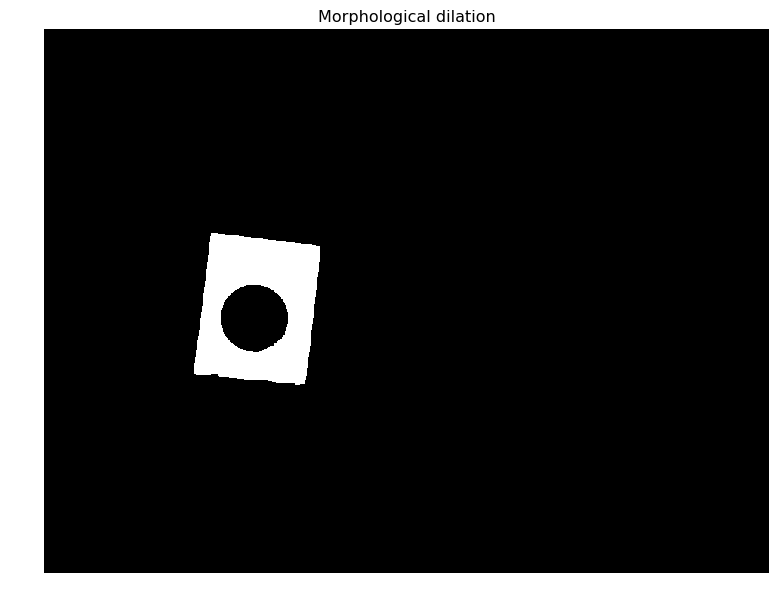

In [8]:
# Get back the fine boundary edges using dilation
kernel1 = np.ones((2, 2), np.uint8)
dilation = cv2.dilate(closing, kernel1, iterations = 1)

show_image(dilation, 'Morphological dilation', 'gray')

In the above image, the missing circle in the center is due to the presence of non-yellow concentric circles on the *matchbox*. To get the complete *matchbox*, the property of contours is exploited as shown below.

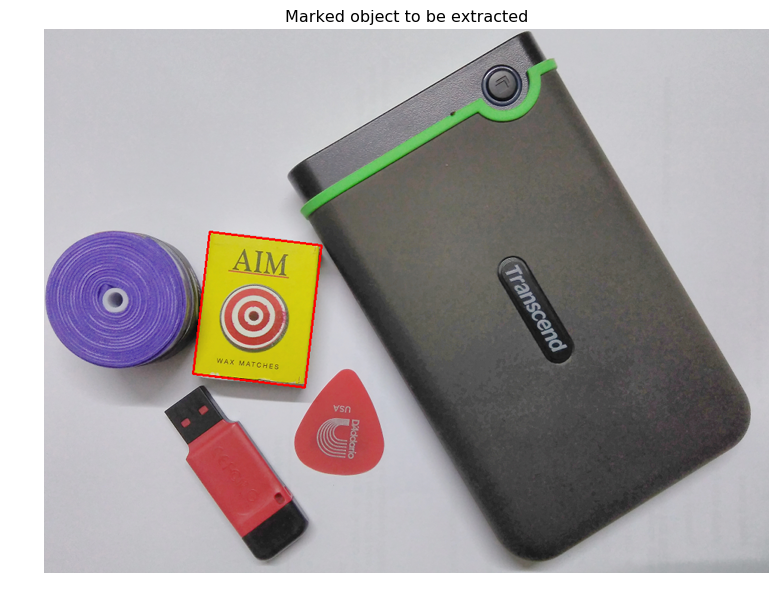

In [9]:
_, contours, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# There are 2 contours: outer one is the rectangle(ish) and inner one is the circle(ish)
# Get the outer contour (it has larger area than the inner contour)
c1 = max(contours, key = cv2.contourArea)

# Define the bounding rectangle around the contour
rect = cv2.minAreaRect(c1)

# Get the 4 corner coordinates of the rectangle
box = cv2.boxPoints(rect)
box = np.int0(box)

# Draw the bounding rectangle to show the marked object
temp_img = src_img.copy()
bdg_rect = cv2.drawContours(temp_img, [box], 0, (0, 0, 255), 2)

show_image(bdg_rect, 'Marked object to be extracted', 'RGB')

The *matchbox* is marked in red in the above image. It is extracted by applying geometric transformations on the image and the result is saved as the query image.

In [10]:
# cv2.boxPoints(rect) returns the coordinates (x, y) as the following list:
# [[bottom right], [bottom left], [top left], [top right]]

width = box[0][0] - box[1][0]
height = box[1][1] - box[2][1]

src_pts = box.astype('float32')
dst_pts = np.array([[width, height],
                    [0, height],
                    [0, 0],
                    [width, 0]], dtype = 'float32')

# Get the transformation matrix
M = cv2.getPerspectiveTransform(src_pts, dst_pts)

# Apply the perspective transformation
warped = cv2.warpPerspective(src_img, M, (width, height))

# Save the query image
cv2.imwrite('images/query.png', warped)

True

## 2. Feature detection and matching

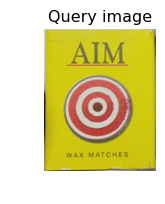

In [11]:
# Load and display the query image
query_img = cv2.imread('images/query.png')

show_image(query_img, 'Query image', 'RGB')

The visualization below shows the detected features of the *matchbox*.

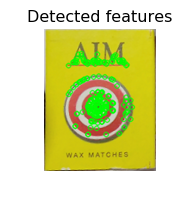

In [12]:
# Create an ORB object
orb = cv2.ORB_create()

# Detect and visualize the features
features = orb.detect(query_img, None)
f_img = cv2.drawKeypoints(query_img, features, None, color = (0, 255, 0), flags = 0)

show_image(f_img, 'Detected features', 'RGB')

To uniquely identify the *matchbox* in any given image (train image):
* detect and describe its features
* detect and describe the features in the train image
* match the features in both images based on their descriptors
* extract good matches based on the nearest neighbour ratio
* get the locations of matched features in both the images and apply perspective transformation to find the *matchbox*

In [13]:
# Function to match features and find the object
def match_feature_find_object(query_img, train_img, min_matches): 
    # Create an ORB object
    orb = cv2.ORB_create(nfeatures=100000)
    
    features1, des1 = orb.detectAndCompute(query_img, None)
    features2, des2 = orb.detectAndCompute(train_img, None)

    # Create Brute-Force matcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(des1, des2, k = 2)
    
    # Nearest neighbour ratio test to find good matches
    good = []    
    good_without_lists = []    
    matches = [match for match in matches if len(match) == 2] 
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append([m])
            good_without_lists.append(m)
         
    if len(good) >= min_matches:
        # Draw a polygon around the recognized object
        src_pts = np.float32([features1[m.queryIdx].pt for m in good_without_lists]).reshape(-1, 1, 2)
        dst_pts = np.float32([features2[m.trainIdx].pt for m in good_without_lists]).reshape(-1, 1, 2)
        
        # Get the transformation matrix
        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
               
        # Find the perspective transformation to get the corresponding points
        h, w = query_img.shape[:2]
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)
        
        train_img = cv2.polylines(train_img, [np.int32(dst)], True, (0, 255, 0), 2, cv2.LINE_AA)
    else:
        print('Not enough good matches are found - {}/{}'.format(len(good), min_matches))
            
    result_img = cv2.drawMatchesKnn(query_img, features1, train_img, features2, good, None, flags = 2)
    
    show_image(result_img, 'Feature matching and object recognition', 'RGB')

## 3. Result

The result on several images with different setup is shown below. The identified *matchbox* is marked in green color in the train images. The matched features are also shown.

Note: When the the front face of the *matchbox* is not coplanar with the camera's view in the train image, then some corners of the green bounding box are slightly shifted. Higher the non-coplanarity, higher is the deviation. This is due to the requirement of cv2.findHomography() that the source and destination points should be coplanar.

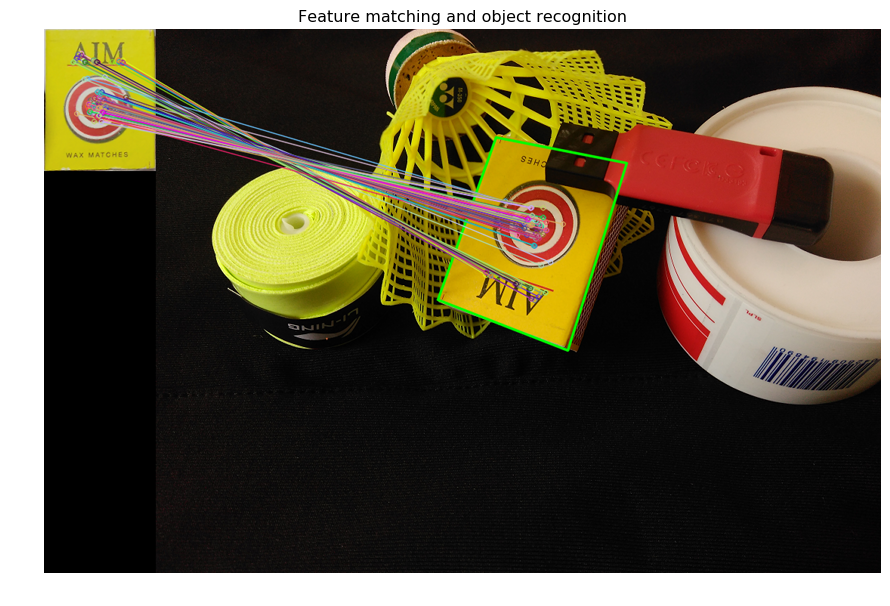

In [14]:
train_img = cv2.imread('images/train1.png')
match_feature_find_object(query_img, train_img, 10)

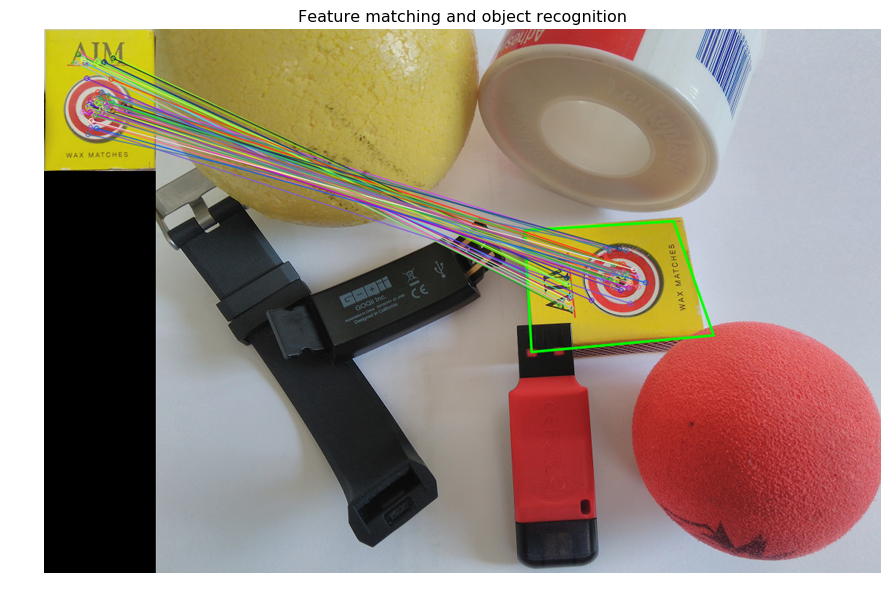

In [15]:
train_img = cv2.imread('images/train2.png')
match_feature_find_object(query_img, train_img, 10)

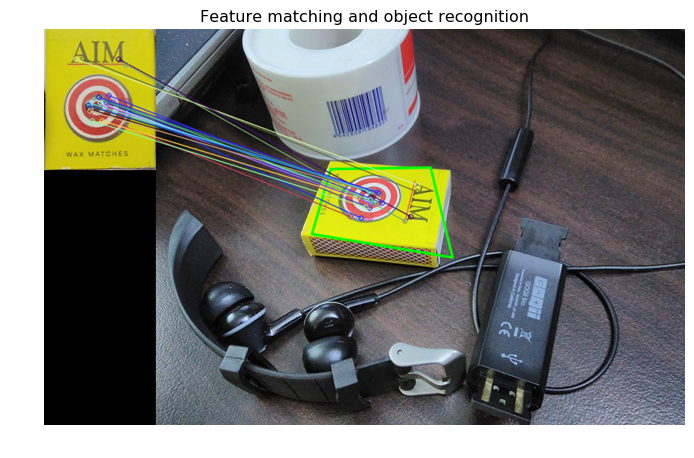

In [16]:
train_img = cv2.imread('images/train3.jpg')
match_feature_find_object(query_img, train_img, 10)

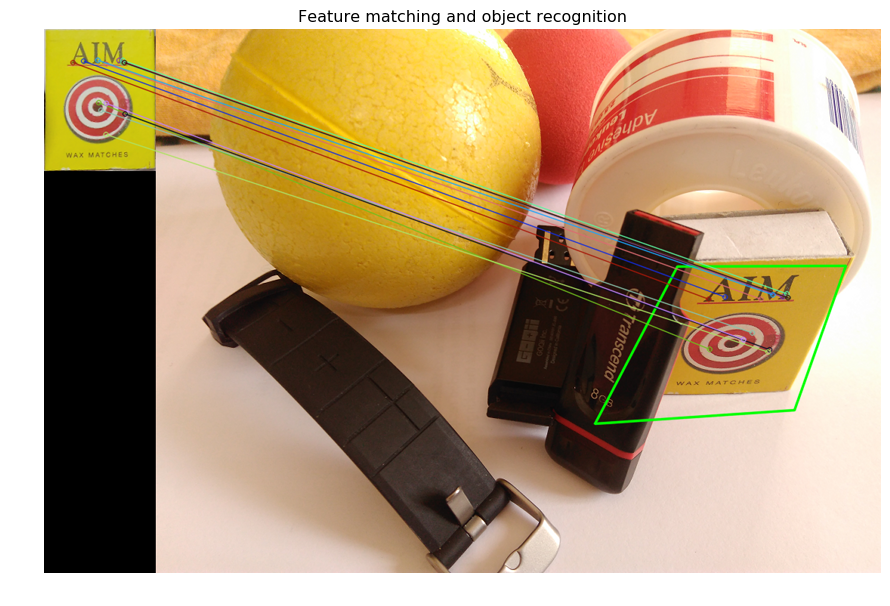

In [17]:
train_img = cv2.imread('images/train4.png')
match_feature_find_object(query_img, train_img, 10)

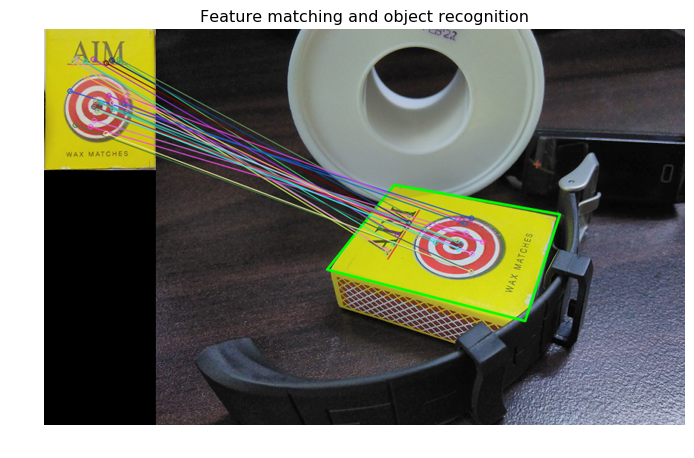

In [18]:
train_img = cv2.imread('images/train5.jpg')
match_feature_find_object(query_img, train_img, 10)

Not enough good matches are found - 2/10


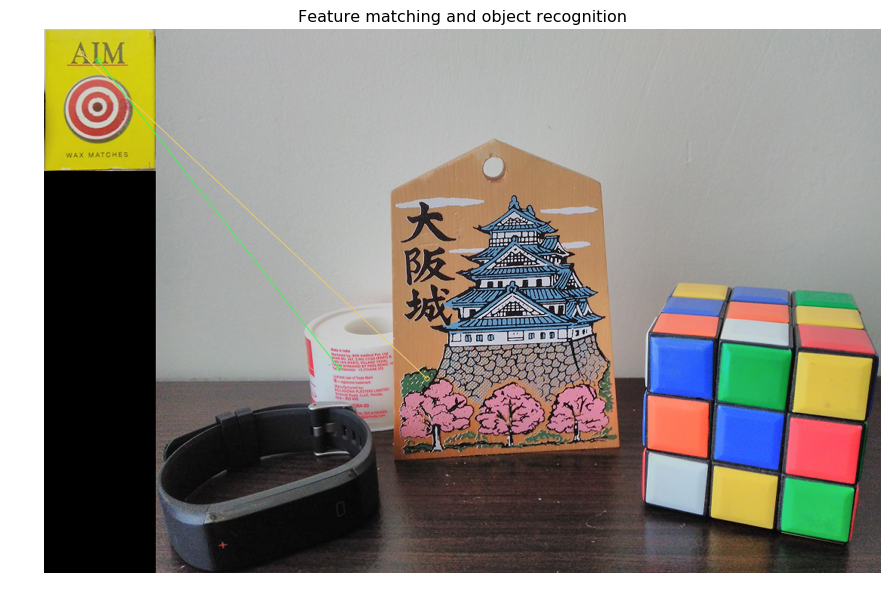

In [19]:
# Image without the matchbox
train_img = cv2.imread('images/train6.jpg')
match_feature_find_object(query_img, train_img, 10)

Not enough good matches are found - 1/10


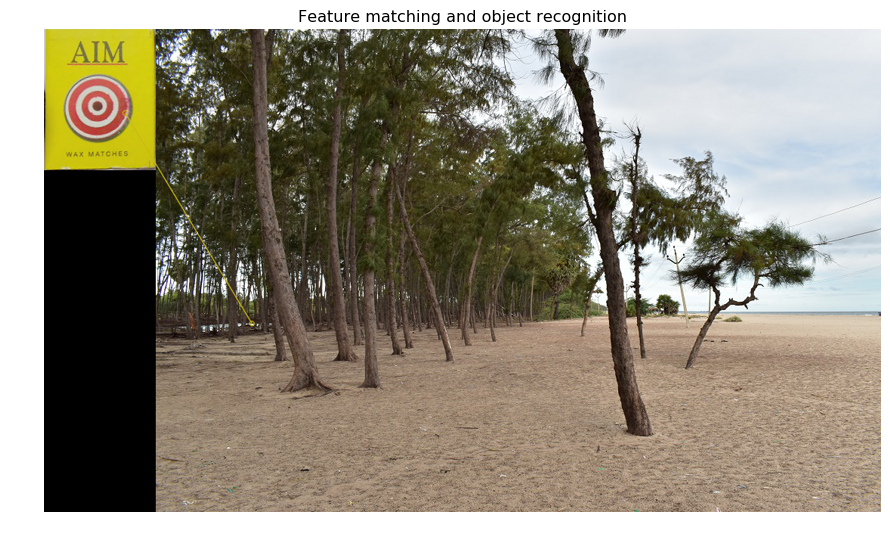

In [21]:
# Image without the matchbox
train_img = cv2.imread('images/train7.jpg')
match_feature_find_object(query_img, train_img, 10)